## Objective: Learn how to predict apartments' renting price in Champaign, IL

Remember to shut down your server when you are done by clicking Control Panel -> Shut Down Server

### Step 1: Data Preprocessing
We need to preprocess data before we start running a machine learning algorithm. The reasons are that some observations are invalid (missing rent number) or some columns do not provide enough information (like image_urls).

First of all, we need to load a raw csv file

In [4]:
setwd('/home/ubuntu/labs/Lab_5_ML_Prediction')
ipak <- function(pkg){
new.pkg <- pkg[!(pkg %in% installed.packages()[, "Package"])]
if (length(new.pkg)) 
    install.packages(new.pkg, dependencies = TRUE)
sapply(pkg, require, character.only = TRUE)
}

# usage
packages <- c("rgdal", "sp", "xgboost")
ipak(packages)

rgdal      sp xgboost 
   TRUE    TRUE    TRUE

In [5]:
# Load the data from /home/zhang303/Apartments
# Here, we read the data crawled from apartments on 2017-06-13 (rents-2017-06-13.csv)
# Raw is a dataframe that consists of 305278 observations.
raw <- read.csv("rents_2017-06-13.csv")

Now we need to find every apartment in Champaign, IL. To do that, we can do some basic queries

In [6]:
# Grab all the data that meets the criteria
data = raw[raw$state == "IL" & raw$city == "Champaign",]
states = "IL"

In [7]:
data[4,]

,address,city,state,zipcode,rent,beds,baths,sqft,image_urls,description,⋯,url,score,source,contact,email,lat,lon,apt_number,last_update,Date.Added
144497,"1010 S 1st St, Champaign, IL 61820, USA",Champaign,IL,61820,$624-$645,1,1,-,http://www.placeofmine.com/images/no-image.gif,"Short term lease starting at $624.00 ending on August 5th, 2017. Spacious garden level 1 bedroom/ 1 bath located in the heart of campus. Rental amount includes water, sewer, trash and recycling. Tenant responsible for electric, gas (stove) and internet/cable. Call us to schedule a tour today",⋯,http://kennedywilson.linkedupradio.com/properties?property_id=14069&#9;&#9;&#9;&#9;&#9;&#9;&#9;&#9;&#9;,46.3411,cu-living.com,217-384-5555,-,40.10597,-88.23828,-,2017-03-31 15:42:15,06-13-2017


In [8]:
nrow(data)
ncol(data)

[1] 150

[1] 22

Champaign should be a dataframe that contains 150 observations with 22 variables. Now we need to integrate the raw data with the census block data 

In [9]:
# A function that translates a state into a code.
# For example, codeForState(IL) = 17
codeForState <- function (state_name) {
  if (!exists('stateCodeMap')) {
    stateCodeMap = read.csv('state_code_map.csv')
  }
  code = stateCodeMap[which(stateCodeMap$state==state_name),"code"]
  if (nchar(code) < 2) {
    code = paste0("0",code)
  }
  return(code)
}

In [10]:
# example
codeForState("IL")

[1] 17

In [11]:
# get POP data for Illinois
getPOPDataForState <- function (data,state_name) {
  # Get layer name & path
  layer_name = paste0("tl_2016_",codeForState(state_name),"_tabblock10")
  shape_object_path = paste0(codeForState(state_name),"_shp.rds")
  
  if (!file.exists(shape_object_path)) {
    return(NA)
  }
  
  # Grab just the rows for the state we're processing
  state_subset = subset(data,state==state_name)
  
  # If there are no rows for this state, do nothing
  if(dim(state_subset)[1]==0) {
    return(NA)
  } else {
    points_raw = state_subset
    points_raw$lat = as.numeric(points_raw$lat)
    points_raw$lon = as.numeric(points_raw$lon)
      
    source("PointsOverPolygons.R",local = TRUE)
    if (!exists("aug_points")) {
      stop("PointsOverPolygons.R failed to create membership data.")
    }
  }
  return(aug_points)
}

# usage in the next cell
# example output in the 3 cells later

In [12]:
# In a real project we run every state in the U.S., but here we only run Illinois.
# Don't worry about the warning messages
aug_data_by_state = lapply("IL",function(state_name) {
  print(paste0("Working on ",state_name,"..."))
    
  if (state_name == "") {
    return(NA)
  }
    
  aug_data = getPOPDataForState(data,state_name)
    
  return(aug_data)
})

[1] "Working on IL..."


Loading required package: readxl
Loading required package: data.table
Loading required package: rgeos
rgeos version: 0.3-28, (SVN revision 572)
 GEOS runtime version: 3.5.1-CAPI-1.9.1 r4246 
 Linking to sp version: 1.3-1 
 Polygon checking: TRUE 

Loading required package: tools


   user  system elapsed 
 51.136   0.820  51.955 


In [13]:
# Remove any states that had no rows in them.
aug_data_by_state_no_NAs = aug_data_by_state[which(!is.na(aug_data_by_state))]
aug_data = Reduce(rbind,aug_data_by_state_no_NAs,aug_data_by_state_no_NAs[[1]][c(),])

In [14]:
aug_data[4,]

,address,city,state,zipcode,rent,beds,baths,sqft,image_urls,description,⋯,MTFCC10,UR10,UACE10,UATYPE,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,addedID
144497,"1010 S 1st St, Champaign, IL 61820, USA",Champaign,IL,61820,$624-$645,1,1,-,http://www.placeofmine.com/images/no-image.gif,"Short term lease starting at $624.00 ending on August 5th, 2017. Spacious garden level 1 bedroom/ 1 bath located in the heart of campus. Rental amount includes water, sewer, trash and recycling. Tenant responsible for electric, gas (stove) and internet/cable. Call us to schedule a tour today",⋯,G5040,U,15211,U,S,17924,0,+40.1059648,-088.2378272,43213


After integration, we can remove columns that do not have enough information such as image_urls.

In [17]:
# a function that removes useless variables and categorizes by square ft
cleanChunk = function (chunk_old) {

  chunk=data.frame(matrix(nrow=nrow(chunk_old),ncol=0))
    
  #chunk$id <- chunk_old$csv_id
  chunk$Lat_Num <- as.numeric(chunk_old$lat)
  chunk$Lon_Num <- as.numeric(chunk_old$lon)
  chunk$Sqft_Num <- as.numeric(chunk_old$sqft)
  chunk$Score_Num <- as.numeric(chunk_old$score)
  chunk_old$rent1 <- sub("$",'',as.character(chunk_old$rent),fixed=TRUE)
  chunk$Rent_Num <- as.numeric(sub(",",'',as.character(chunk_old$rent1),fixed=TRUE))
  chunk$Zip_Fac <- as.factor(chunk_old$zipcode)
  chunk$Beds_Num <- as.numeric(chunk_old$beds)
  chunk$Baths_Num <- as.numeric(chunk_old$baths)
  chunk$Beds_Fac <- as.factor(chunk_old$beds)
  chunk$Baths_Fac <- as.factor(chunk_old$baths)
  chunk$DateAdded_Str <- as.character(chunk_old$Date.Added)

  chunk$State_Fac <- as.factor(chunk_old$STATEFP10)
  chunk$Tract_Fac <- as.factor(chunk_old$TRACTCE10)
  chunk$Block_Fac <- as.factor(chunk_old$BLOCKCE10)
  chunk$Date_Fac <- as.factor(chunk_old$Date.Added)

  chunk$Sqft0500 <- as.factor(chunk$Sqft_Num<500)
  chunk$Sqft500600 <- as.factor(chunk$Sqft_Num>=500 & chunk$Sqft_Num<600)
  chunk$Sqft600700 <- as.factor(chunk$Sqft_Num>=600 & chunk$Sqft_Num<700)
  chunk$Sqft700800 <- as.factor(chunk$Sqft_Num>=700 & chunk$Sqft_Num<800)
  chunk$Sqft800900 <- as.factor(chunk$Sqft_Num>=800 & chunk$Sqft_Num<900)
  chunk$Sqft9001000 <- as.factor(chunk$Sqft_Num>=900 & chunk$Sqft_Num<1000)
  chunk$Sqft10001100 <- as.factor(chunk$Sqft_Num>=1000 & chunk$Sqft_Num<1100)
  chunk$Sqft11001200 <- as.factor(chunk$Sqft_Num>=1100 & chunk$Sqft_Num<1200)
  chunk$Sqft12001300 <- as.factor(chunk$Sqft_Num>=1200 & chunk$Sqft_Num<1300)
  chunk$Sqft13001400 <- as.factor(chunk$Sqft_Num>=1300 & chunk$Sqft_Num<1400)
  chunk$Sqft14001500 <- as.factor(chunk$Sqft_Num>=1400 & chunk$Sqft_Num<1500)
  chunk$Sqft15001600 <- as.factor(chunk$Sqft_Num>=1500 & chunk$Sqft_Num<1600)
  chunk$Sqft16001700 <- as.factor(chunk$Sqft_Num>=1600 & chunk$Sqft_Num<1700)
  chunk$Sqft17001800 <- as.factor(chunk$Sqft_Num>=1700 & chunk$Sqft_Num<1800)
  chunk$Sqft18001900 <- as.factor(chunk$Sqft_Num>=1800 & chunk$Sqft_Num<1900)
  chunk$Sqft19002000 <- as.factor(chunk$Sqft_Num>=1900 & chunk$Sqft_Num<2000)
  chunk$Sqft2000 <- as.factor(chunk$Sqft_Num>=2000)
  
  chunk$Sqft20002100 <- as.factor(chunk$Sqft_Num>=2000 & chunk$Sqft_Num<2100)
  chunk$Sqft21002200 <- as.factor(chunk$Sqft_Num>=2100 & chunk$Sqft_Num<2200)
  chunk$Sqft22002300 <- as.factor(chunk$Sqft_Num>=2200 & chunk$Sqft_Num<2300)
  chunk$Sqft23002400 <- as.factor(chunk$Sqft_Num>=2300 & chunk$Sqft_Num<2400)
  chunk$Sqft24002500 <- as.factor(chunk$Sqft_Num>=2400 & chunk$Sqft_Num<2500)
  chunk$Sqft25002600 <- as.factor(chunk$Sqft_Num>=2500 & chunk$Sqft_Num<2600)
  chunk$Sqft26002700 <- as.factor(chunk$Sqft_Num>=2600 & chunk$Sqft_Num<2700)
  chunk$Sqft27002800 <- as.factor(chunk$Sqft_Num>=2700 & chunk$Sqft_Num<2800)
  chunk$Sqft28002900 <- as.factor(chunk$Sqft_Num>=2800 & chunk$Sqft_Num<2900)
  chunk$Sqft29003000 <- as.factor(chunk$Sqft_Num>=2900 & chunk$Sqft_Num<3000)
  chunk$Sqft3000 <- as.factor(chunk$Sqft_Num>=3000)
  chunk$Sqft2000 <- as.factor(chunk$Sqft_Num>=2000)
  chunk$Sqft01000 <- as.factor(chunk$Sqft_Num<1000)
  
  chunk$Location_GeoJSON = data.frame(matrix(NA,nrow=nrow(chunk_old),ncol=2,dimnames = list(c(),c("type","coordinates"))))
  chunk$Location_GeoJSON$coordinates = as.list(data.frame(apply(chunk_old[c("lat","lon")],1,function(f){
    return(c(as.numeric(f["lon"]),as.numeric(f["lat"])))
  })))
    
  chunk$Location_GeoJSON$type = "Point"
  
  chunk <- subset(chunk, Rent_Num!="NA")

  print("finished")
  return(subset(chunk, Rent_Num <= 5035))
}

clean <- cleanChunk(aug_data)
# It's fine if you see the folling warning message
# Warning message in cleanChunk(aug_data):
# “NAs introduced by coercion”

Warning message in cleanChunk(aug_data):
“NAs introduced by coercion”

[1] "finished"


### Step 2: Modeling
After processing the data, we split the whole dataset into train/test set so we can run a machine learning algorithm on it.

In [18]:
## Setting 80% as train and 20% as test
sample_size <- floor(0.8 * nrow(clean))

## Set the seed to make your partition reproductible
set.seed(123)

train_ind <- sample(seq_len(nrow(clean)), size = sample_size)

In [19]:
train <- clean[train_ind,]
test <- clean[-train_ind,]

In [20]:
## Print first 5 rows of the train data.
print(train[1:5,])

     Lat_Num   Lon_Num Sqft_Num Score_Num Rent_Num Zip_Fac Beds_Num Baths_Num
41  40.12516 -88.29663     5092  57.33269      675   61822       16         4
129 40.10479 -88.25331        1  57.72904     1150   61820       49         1
52  40.12754 -88.28770     4786  56.75846      560   61821       16         4
136 40.10519 -88.23863        1  48.61798      540   61820       16         1
140 40.10733 -88.23738        1  55.95307      850   61820       44        30
    Beds_Fac Baths_Fac DateAdded_Str State_Fac Tract_Fac Block_Fac   Date_Fac
41         1         1    06-13-2017        17    000902      1090 06-13-2017
129        4         -    06-13-2017        17    000500      2008 06-13-2017
52         1         1    06-13-2017        17    000902      2023 06-13-2017
136        1         -    06-13-2017        17    000402      2006 06-13-2017
140        3         2    06-13-2017        17    000402      2002 06-13-2017
    Sqft0500 Sqft500600 Sqft600700 Sqft700800 Sqft800900 Sqft900

We are using XGBoost in this example. XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. 
Before we start training our model, first we need to translate categorical variables into numeric values. (because XGBoost doesn't take categorical variables)

In [21]:
# Import library
library(xgboost)

In [22]:
# Get rid of Location_GeoJSON because we don't need them
train_no_json = train[,!names(train) %in% c("Location_GeoJSON")]
test_no_json = test[,!names(test) %in% c("Location_GeoJSON")]

# Change type of DateAdded_Str to Date
train_no_json$DateAdded_Str <- as.Date(train_no_json$DateAdded_Str, format = "%m-%d-%Y")
test_no_json$DateAdded_Str <- as.Date(test_no_json$DateAdded_Str, format = "%m-%d-%Y")

# From columns 14 to 42, if the value is true then change it to 1, otherwise 0
train_no_json[, 14:42] <- as.integer(train_no_json[, 14:42] == "TRUE")
test_no_json[, 14:42] <- as.integer(test_no_json[, 14:42] == "TRUE")

# Store the rent we are going to predict and delete it from the train data set
output_vector = train_no_json[,"Rent_Num"]
train_no_json = train_no_json[,!names(train_no_json) %in% c("Rent_Num")]

# Store the rent we are going to predict and delete it from the test data set
true_vector = test_no_json[, "Rent_Num"]
test_no_json = test_no_json[,!names(test_no_json) %in% c("Rent_Num")]

In [23]:
# Change to matrix because XGBoost takes matrices
train_numeric <- data.matrix(train_no_json)
test_numeric <- data.matrix(test_no_json)

dtrain <- xgb.DMatrix(data = train_numeric, label = output_vector)
dtest <- xgb.DMatrix(data = test_numeric, label = true_vector)

# We can see the rmse of train and test via using watchlist parameter 
watchlist <- list(train = dtrain, test = dtest)

Now we only need to put correct parameters into the model and train it. 
From the output you can see the rmse decrease after each round of training

In [24]:
# data: training data
# max.depth: maximum depth of the tree
# eta: step size
# gamma: minimum loss reduction
# subsample: subsample ratio of the training instance
# nround: number of rounds
# watchlist: watchlist
# objective: regression or classification
model <- xgb.train(data = dtrain,
                   max.depth = 300, 
                   eta = 0.1, 
                   gamma = 0.01,
                   subsample = 0.5,
                   nround = 50,
                   watchlist = watchlist, 
                   print_every_n = 10,
                   objective = "reg:linear")

[1]	train-rmse:806.593811	test-rmse:776.394531 
[11]	train-rmse:388.661407	test-rmse:364.412109 
[21]	train-rmse:221.509155	test-rmse:247.851868 
[31]	train-rmse:152.884186	test-rmse:204.970291 
[41]	train-rmse:108.237511	test-rmse:197.752731 
[50]	train-rmse:85.646523	test-rmse:194.536774 


You can play around with the parameters. The list of all available parameters are in here: https://xgboost.readthedocs.io/en/latest/parameter.html

In [25]:
# xgb.importance is a function that calculates the importance of each variable
importance_matrix <- xgb.importance(feature_names = colnames(train_numeric), model = model)
print(importance_matrix)

         Feature         Gain       Cover   Frequency
 1:      Lat_Num 0.2312742876 0.230731286 0.355882353
 2:     Beds_Num 0.1965108017 0.131582193 0.095588235
 3:    Score_Num 0.1667126677 0.165001850 0.164705882
 4:    Baths_Num 0.1382307283 0.083117524 0.048529412
 5:      Lon_Num 0.1370149994 0.237760513 0.192647059
 6:    Tract_Fac 0.0642299278 0.055617215 0.042647059
 7:      Zip_Fac 0.0383429974 0.035886053 0.020588235
 8:     Sqft_Num 0.0261702322 0.048834628 0.069117647
 9: Sqft11001200 0.0011114957 0.006042669 0.002941176
10:  Sqft9001000 0.0002808017 0.002466395 0.005882353
11:   Sqft600700 0.0001210606 0.002959674 0.001470588


In [26]:
# Now we can start predicting the testing set and visualize the result.
model$pred <- predict(model, test_numeric)
test$res <- test$Rent_Num - model$pred

`geom_smooth()` using method = 'loess'


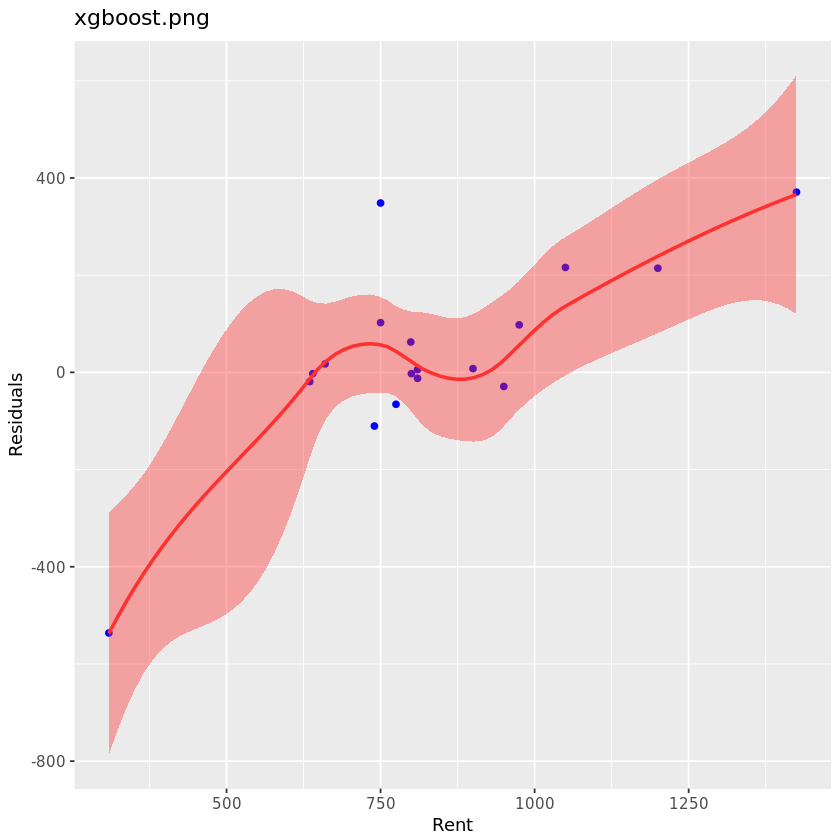

In [27]:
# visualize
library(ggplot2)
name <- "xgboost"
ggplot() + ggtitle(paste(name,".png",sep="")) +
      labs(x="Rent", y="Residuals") +
      geom_point(aes(test$Rent_Num, test$res),
                 colour='blue', fill = "blue") +
      geom_smooth(aes(test$Rent_Num, test$res), se=TRUE, fullrange=FALSE,
                  colour='firebrick1', fill = "firebrick1")

## Question:
Try to tune the model's parameters. If you increase the eta or the maximum depth, what will happen? Can you explain your reasoning? Are there other ways to improve the model's performance?

In [31]:
model <- xgb.train(data = dtrain,
                   max.depth = 1000, 
                   eta = 0.1, 
                   gamma = 0.01,
                   subsample = 0.5,
                   nround = 50,
                   watchlist = watchlist, 
                   print_every_n = 10,
                   objective = "reg:linear")


[1]	train-rmse:814.026123	test-rmse:788.593262 
[11]	train-rmse:383.192383	test-rmse:369.723114 
[21]	train-rmse:206.492615	test-rmse:227.289581 
[31]	train-rmse:136.222672	test-rmse:195.300873 
[41]	train-rmse:90.560486	test-rmse:184.733307 
[50]	train-rmse:67.086845	test-rmse:179.761627 


In [32]:
importance_matrix <- xgb.importance(feature_names = colnames(train_numeric), model = model)
print(importance_matrix)

        Feature         Gain        Cover   Frequency
 1:     Lat_Num 0.2371851705 0.1160379882 0.143779343
 2:     Lon_Num 0.2028283706 0.5868111289 0.656103286
 3:    Beds_Num 0.1624755887 0.0636035313 0.035211268
 4:   Baths_Num 0.1462776581 0.0589218834 0.027582160
 5:   Score_Num 0.1396657251 0.0902889246 0.069248826
 6:    Sqft_Num 0.0397419719 0.0321027287 0.031103286
 7:   Tract_Fac 0.0385849363 0.0255484216 0.021713615
 8:     Zip_Fac 0.0327127300 0.0230069556 0.009976526
 9: Sqft9001000 0.0003489707 0.0028089888 0.004107981
10:  Sqft700800 0.0001788781 0.0008694489 0.001173709


In [34]:
Increasing the max.depth from 300 to 100 can reduce the test-rmse as it allows more complex functional forms. 
From:
[1]	train-rmse:806.593811	test-rmse:776.394531 
[11]	train-rmse:388.661407	test-rmse:364.412109 
[21]	train-rmse:221.509155	test-rmse:247.851868 
[31]	train-rmse:152.884186	test-rmse:204.970291 
[41]	train-rmse:108.237511	test-rmse:197.752731 
[50]	train-rmse:85.646523	test-rmse:194.536774 
to:
[1]	train-rmse:814.026123	test-rmse:788.593262 
[11]	train-rmse:383.192383	test-rmse:369.723114 
[21]	train-rmse:206.492615	test-rmse:227.289581 
[31]	train-rmse:136.222672	test-rmse:195.300873 
[41]	train-rmse:90.560486	test-rmse:184.733307 
[50]	train-rmse:67.086845	test-rmse:179.761627 

K-folds cross validation should improve the test rmse further as over-fitting is avoided.

ERROR: Error in parse(text = x, srcfile = src): <text>:1:12: unexpected symbol
1: Increasing the
               ^
